In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys

import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c
from py21cmfast import plotting, cache_tools

print(f'Using 21cmFAST version {p21c.__version__}')
p21c.config['direc'] = '/scratch/submit/ctp/yitians/21cmFAST-cache'

Using 21cmFAST version 0.1.dev1578+g6f96f89.d20230216


/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [3]:
def get_circle(size):
    im = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if (i-(size-1)/2)**2 + (j-(size-1)/2)**2 < (0.3*size)**2:
                im[i,j] = 1
    return im

def get_circle_seq_at(size, n_per_side, at_i):
    bs = int(np.floor(size/n_per_side))
    at_i = at_i % n_per_side**2
    i = at_i // n_per_side
    j = at_i %  n_per_side
    im = np.zeros((size,size))
    im[i*bs:(i+1)*bs, j*bs:(j+1)*bs] = get_circle(bs)
    return np.einsum('i,jk->ijk', np.ones((size,)), im)

## 1. Test run

In [4]:
cache_tools.clear_cache()

2023-02-18 02:00:15,918 | INFO | Removing PerturbedField_efd2cbfb11c49cdc787c44bd838c08e3_r54321.h5
2023-02-18 02:00:15,923 | INFO | Removing PerturbedField_90a898f9a6259155613ab20b1ad1ea16_r54321.h5
2023-02-18 02:00:15,931 | INFO | Removing TsBox_0df99e8163012efb3503637ea3f74107_r54321.h5
2023-02-18 02:00:15,936 | INFO | Removing PerturbedField_4d0994024c25cc76e867d8a59272b882_r54321.h5
2023-02-18 02:00:15,943 | INFO | Removing TsBox_7f326fabab58f7fd12efdc5bd7ac063f_r54321.h5
2023-02-18 02:00:15,951 | INFO | Removing TsBox_f0e8df5a2b3a7ff46a61c27f408b1605_r54321.h5
2023-02-18 02:00:15,956 | INFO | Removing PerturbedField_0a7308a0387aac0bceb0e97e6dfcdc57_r54321.h5
2023-02-18 02:00:15,961 | INFO | Removing PerturbedField_ce3c909b3d4f57d16e2e4304bee42de4_r54321.h5
2023-02-18 02:00:15,968 | INFO | Removing TsBox_3cf87fed501b1a4ebd950b5b55cffbec_r54321.h5
2023-02-18 02:00:15,973 | INFO | Removing PerturbedField_0642239da73af0bfdd34d01e8a390c9d_r54321.h5
2023-02-18 02:00:15,981 | INFO | Rem

In [5]:
initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": 50, "BOX_LEN": 50},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321
)
perturbed_field = p21c.perturb_field(redshift=25.0, init_boxes=initial_conditions)

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/inputs.py:488: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  "The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be "


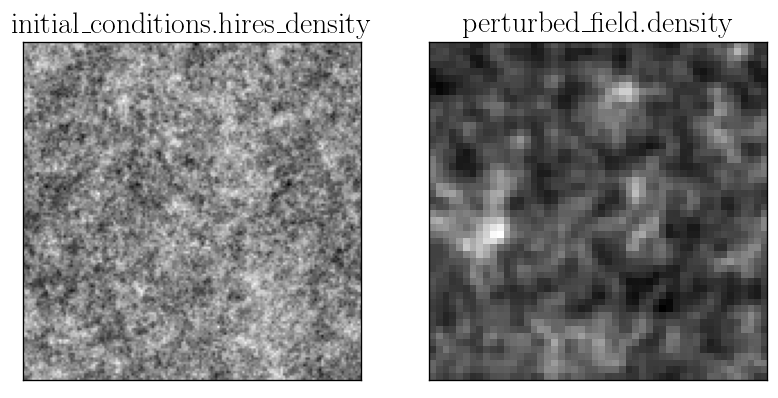

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].imshow(initial_conditions.hires_density[25], cmap='binary_r')
axs[1].imshow(perturbed_field.density[25], cmap='binary_r')

axs[0].set(title='initial_conditions.hires_density', xticks=[], yticks=[])
axs[1].set(title='perturbed_field.density', xticks=[], yticks=[]);

In [7]:
# redshift array
rs_arr = 35*1.05**(-np.array(range(10)))
print(rs_arr)

[35.         33.33333333 31.74603175 30.23431595 28.79458662 27.42341583
 26.11753888 24.87384655 23.68937767 22.56131207]


In [8]:
Tk_box_arr = []

for i_rs, rs in enumerate(rs_arr):
    
    print(i_rs, rs)
    
    # input
    input_heating = p21c.input_heating(redshift=rs, init_boxes=initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=rs, init_boxes=initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=rs, init_boxes=initial_conditions, write=False)

    input_heating.input_heating += get_circle_seq_at(50, 3, i_rs)
    input_ionization.input_ionization += get_circle_seq_at(50, 5, 9-i_rs) * 1e-3
    
    # perturbed_field to control redshift
    perturbed_field = p21c.perturb_field(redshift=rs, init_boxes=initial_conditions)
    
    # calculate spin temperature
    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=(None if i_rs==0 else spin_temp),
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        write=True
    )
    Tk_box_arr.append(spin_temp.Tk_box)

0 35.0


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
1 33.33333333333333


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
2 31.746031746031743


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
3 30.23431594860166


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
4 28.794586617715865


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
5 27.42341582639606


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
6 26.117538882281963


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
7 24.873846554554248


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
8 23.689377671004046


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
9 22.5613120676229


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation


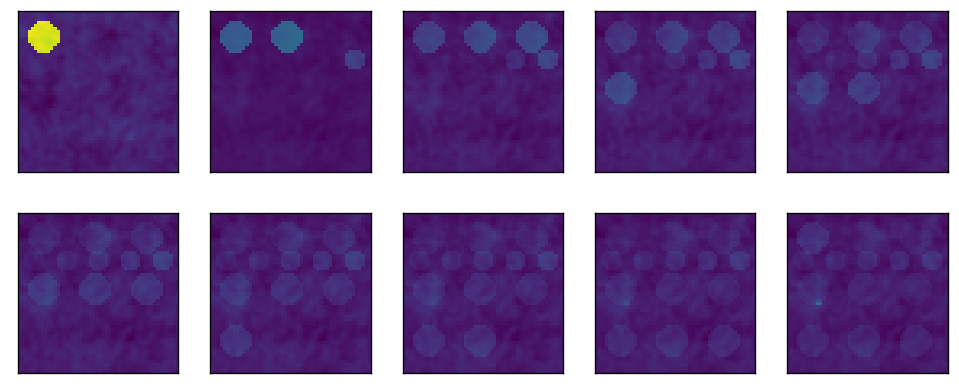

In [9]:
vmax = np.max(Tk_box_arr)

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(Tk_box_arr[i*5+j][25], vmax=vmax)
        axs[i,j].set(xticks=[], yticks=[])

## Archive

[Text(0.5, 1.0, 'input_ionization'), [], []]

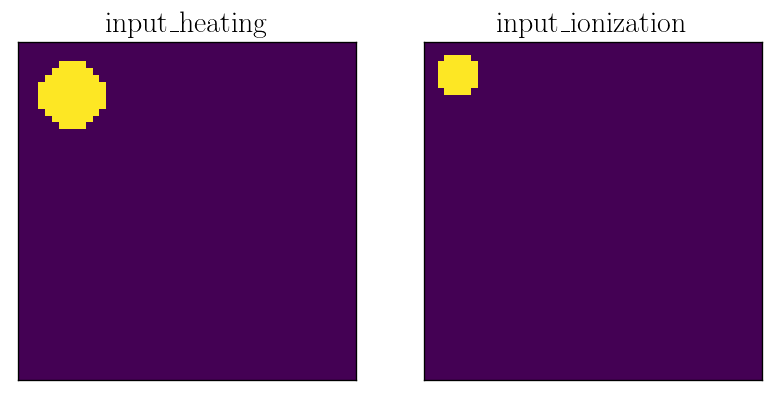

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
im0 = axs[0].imshow(input_heating.input_heating[25])
im1 = axs[1].imshow(input_ionization.input_ionization[25])

axs[0].set(title='input_heating', xticks=[], yticks=[])
axs[1].set(title='input_ionization', xticks=[], yticks=[])

#fig.colorbar(im0, ax=axs[0], orientation='horizontal')
#fig.colorbar(im1, ax=axs[1], orientation='horizontal')

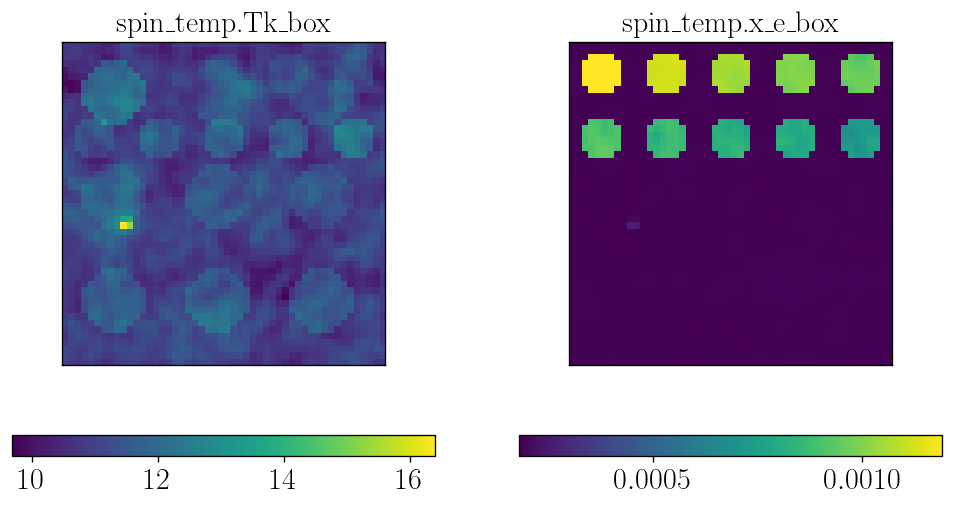

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
im0 = axs[0].imshow(spin_temp.Tk_box[25])
im1 = axs[1].imshow(spin_temp.x_e_box[25])

axs[0].set(title='spin_temp.Tk_box', xticks=[], yticks=[])
axs[1].set(title='spin_temp.x_e_box', xticks=[], yticks=[])

fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')